# Demo LWGNet Reconstructions


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import json
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
import model
from reconstruction_utils import test_reconstruction, reconstructFoV

Load Test data

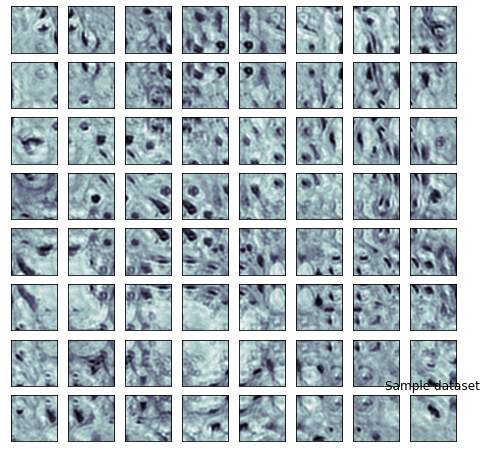

In [3]:
H = 688; W = 688 # FoV pixel dimensions 
nLED = 225 # Number of LEDs

# Load intensity images
I = np.zeros((nLED, H, W))
I = sio.loadmat('TestFoV/Imeas_U16.mat')['Imea'].transpose(2, 0, 1)

# Normalise
I = (I - np.min(I)) / (np.max(I) - np.min(I))
I = np.squeeze(I)

# Segment into 128x128 patches with overlap width=48
# Divide the FoV 8x8 patches
nH = 128; nW = 128 # patch pixel dimensions 
n_ovlap = 48 # overlap pixels
Nr = 8; Nc = 8 # no. of rows and cols
X = []
for k in range(0, Nc):
    for l in range(0, Nr):
        x = k * (nH - n_ovlap)
        y = l * (nW - n_ovlap)
        temp = I[:, x:x+nH, y:y+nW]
        temp = (temp - np.min(temp)) / (np.max(temp) - np.min(temp))
        X.append(temp)
fig = plt.figure('Dataset', figsize=(Nr, Nc))
count = 1
for k in range(0, Nc):
    for l in range(0, Nr):
        ax_a = fig.add_subplot(Nr, Nc, count, xticks = [], yticks = [])
        ax_a.imshow(X[count-1][nLED//2, :, :], cmap='bone')
        count += 1
plt.title("Sample dataset")
X = np.asarray(X) # 64x225x128x128

# Save data
# write_dir = "./TestFLIR_16b_lr/"
# if not os.path.exists(write_dir):
#     os.mkdir(write_dir)

# for k in range(64):
#     name = 'p_'+str(int(1e4+k+1))[1:]+'.mat'
#     sio.savemat(os.path.join(write_dir,name), {"X": X[k, ...]})



In [4]:
# Select device
if torch.cuda.is_available():
  device = "cuda:0"
else:
  device = "cpu"

In [5]:
# Define model configuration 
config = {}
config['root_dir'] = './'
config['dataset'] = []
config['dataset'].append({
        'test_dir': 'TestFLIR_16b_lr',
        'test_filenames': 'test_filenames.txt',
        'test_reconstruction_path': 'recon_flir_16b_lr.mat'
        })
config['params'] = []
config['params'].append({
    'Pupil': 'pupil.mat',
    'K_uv': 'Ns.mat',
    'led_idx': 'idx_led.mat',
    'dim' : 128,
    'scale': 2
    })
config['model'] = []
config['model'].append({
	'num_layers': 3,
	'in_channels': 225,
    'checkpoint_filename': 'models/FLIR-16/checkpoint.pt' 
	})
# with open('config.json5', 'w') as outfile:
#     json.dump(config, outfile, indent=2, sort_keys=False)


In [6]:
# Load configuration 
# f = open("config.json5")
# config = json.load(f)
root_dir = config['root_dir']
dataset_config = config['dataset'][0]
# Create model
model_config = config["model"][0]
model_params = config["params"][0]
idx = []
Ns = np.squeeze(sio.loadmat(os.path.join(root_dir, model_params['K_uv']))['Ns'])
uLed = torch.tensor(Ns[:, 0], dtype=torch.float32)
vLed = torch.tensor(Ns[:, 1], dtype=torch.float32)

h = model_params['dim']
w = model_params['dim']

P = torch.tensor(sio.loadmat(os.path.join(root_dir, model_params['Pupil']))['P'], dtype=torch.uint8)

# Initialize model parameters
opts = {}
opts['numLayers'] = model_config['num_layers']
opts['P'] = P.unsqueeze(0).to(device)
opts['Ns'] = torch.cat((uLed.unsqueeze(0), vLed.unsqueeze(0)), 0)
opts['N'] = (h//2, w//2)
opts['N_obj'] = (h * 2, w * 2)
opts['mu'] = 0.01
opts['scale'] = model_params['scale']
opts['channels'] = 225
opts['dims'] = (h, w)
radius = 50

# Create model
model = model.reconModel(opts, device)

In [ ]:
# Reconstruct 
trainer = test_reconstruction(
        device=device,
        root_dir=root_dir,
        data_config=dataset_config,
        model_config=model_config,
        model_params=model_params,
        model=model
    )
print("Reconstruction in progress...")
trainer._reconstruct()


./models/FLIR-16/checkpoint.pt
Model checkpoint loaded.


In [ ]:
# Plot reconstruction
O_ = np.squeeze(sio.loadmat('recon_flir_16b_lr.mat')["O"])
O = reconstructFoV(np.squeeze(O_))
plt.figure(1)
plt.imshow(-O[-1000:, -1000:], cmap="bone", vmin=-0.9, vmax=0.0)
plt.axis("off")
plt.show()


In [17]:
config['model'][0]['checkpoint_filename'] = 'models/FLIR-12/checkpoint.pt'
config['dataset'][0]['test_filenames'] ='test_filenames.txt'
config['dataset'][0]['test_reconstruction_path'] = 'recon_flir_12b_lr.mat'
dataset_config = config['dataset'][0]
model_config = config["model"][0]
# Reconstruct 
trainer = test_reconstruction(
        device=device,
        root_dir=root_dir,
        data_config=dataset_config,
        model_config=model_config,
        model_params=model_params,
        model=model
    )
print("Reconstruction in progress...")    
trainer._reconstruct()


/Users/Atreyee/Projects/CI-LAB-Temp/checkpoints/Jul_10_FLIR-12/latest_model.pt
Model checkpoint loaded.
Done!
Reconstruction in progress!


In [ ]:
# Plot reconstruction
O_ = np.squeeze(sio.loadmat('recon_flir_12b_lr.mat')["O"])
O = reconstructFoV(np.squeeze(O_))
plt.figure(1)
plt.imshow(-O[-1000:, -1000:], cmap="bone", vmin=-0.9, vmax=0.0)
plt.axis("off")
plt.show()

In [9]:
config['model'][0]['checkpoint_filename'] = 'models/FLIR-8/checkpoint.pt'
config['dataset'][0]['test_filenames'] ='test_filenames.txt'
config['dataset'][0]['test_reconstruction_path'] = 'recon_flir_8b_lr.mat'
dataset_config = config['dataset'][0]
model_config = config["model"][0]
# Reconstruct 
trainer = test_reconstruction(
        device=device,
        root_dir=root_dir,
        data_config=dataset_config,
        model_config=model_config,
        model_params=model_params,
        model=model
    )
print("Reconstruction in progress...")    
trainer._reconstruct()

/Users/Atreyee/Projects/CI-LAB-Temp/checkpoints/Jul_11_FLIR-8/latest_model.pt
Model checkpoint loaded.
Reconstruction in progress...
Done!


In [ ]:
# Plot reconstruction
O_ = np.squeeze(sio.loadmat('recon_flir_8b_lr.mat')["O"])
O = reconstructFoV(np.squeeze(O_))
plt.figure(1)
plt.imshow(-O[-1000:, -1000:], cmap="bone", vmin=-0.9, vmax=0.0)
plt.axis("off")
plt.show()